# 1. Warming Stripes (20 Points)

The British meteorologist Ed Hawkins from the National Centre for Atmospheric Science, University of Reading, came up with the idea to show global warming in terms of colored stripes indicating temperatures above or below a reference temperature with red or blue, respectively. Interactive examples can be studied on the official website [showyourstripes](https://showyourstripes.info/s/europe/germany/nordrheinwestfalen). The development of NRW's mean annual temperature looks like:

<img src="https://raw.githubusercontent.com/rolfbecker/EE_3.07_Geodata_WS2022/main/gdms0000_Final_Assignment/images/EUROPE-Germany-Nordrhein_Westfalen-1881-2021-DW-withlabels.png" alt="Warming Stripes NRW" width="600"  /><br>

You have to produce a similar plot but with several stripes in one diagram. Each stripe would represent the development of annual temperatures at a selection of stations. 


**Sub-Task 1.1:** <br>
Select the stations which are (1) in NRW, (2) still active and (3) started before 1950. It should be **12 stations.** Use **Pandas** to read the station description file [KL_Jahreswerte_Beschreibung_Stationen.txt] (https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/kl/historical/KL_Jahreswerte_Beschreibung_Stationen.txt) from the historical KL data collection.

Have a look at the available Jupyter notebooks in the geodata git repository. Especially the following could be a good starting point: [gdms0180_DWD_NRW_Annual_Temp_vs_Altitude/gnb0181_DWD_NRW_Annual_Temp_vs_Altitude_V001.ipynb](../gdms0180_DWD_NRW_Annual_Temp_vs_Altitude/gnb0181_DWD_NRW_Annual_Temp_vs_Altitude_V001.ipynb)

Modify the notebook according to your needs. 


In [1]:
# The topic of interest
topic_dir = "/annual/kl/historical/"
print("Subdirectory on FTP Server:", topic_dir)

Subdirectory on FTP Server: /annual/kl/historical/


In [2]:
#local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

#local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [3]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//annual/kl/historical/
data/original/DWD//annual/kl/historical/

data/generated/DWD/
data/generated/DWD//annual/kl/historical/
data/generated/DWD//annual/kl/historical/
data/generated/DWD//annual/kl/historical/


## FTP Connection

### Connection Parameters

In [5]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [6]:
# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"

# The absolute ftp directory with the data (topic) of concern
ftp_dir =  ftp_climate_data_dir + topic_dir
print("Absolte FTP directory path with data of concern:", ftp_dir)

Absolte FTP directory path with data of concern: /climate_environment/CDC/observations_germany/climate//annual/kl/historical/


### FTP Connect

In [7]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [8]:
ret = ftp.cwd(".")

### FTP Grab File Function

In [9]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



## Generate Pandas Dataframe from FTP Directory Listing

In [10]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [11]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [12]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,KL_Jahreswerte_Beschreibung_Stationen.txt,.txt,240187,-
1,1,jahreswerte_KL_00001_19310101_19860630_hist.zip,.zip,12989,-
2,3,jahreswerte_KL_00003_18510101_20110331_hist.zip,.zip,20125,-
3,44,jahreswerte_KL_00044_19710301_20211231_hist.zip,.zip,16176,-
4,52,jahreswerte_KL_00052_19730101_20011231_hist.zip,.zip,13759,-
5,61,jahreswerte_KL_00061_19750701_19780831_hist.zip,.zip,9130,-
6,70,jahreswerte_KL_00070_19730601_19860930_hist.zip,.zip,9680,-
7,71,jahreswerte_KL_00071_19861101_20191231_hist.zip,.zip,14916,-
8,72,jahreswerte_KL_00072_19781001_19950531_hist.zip,.zip,12892,-
9,73,jahreswerte_KL_00073_19530101_20211231_hist.zip,.zip,17379,-


### Dataframe with TS Zip Files

In [13]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
1,jahreswerte_KL_00001_19310101_19860630_hist.zip,.zip,12989,-
3,jahreswerte_KL_00003_18510101_20110331_hist.zip,.zip,20125,-
44,jahreswerte_KL_00044_19710301_20211231_hist.zip,.zip,16176,-
52,jahreswerte_KL_00052_19730101_20011231_hist.zip,.zip,13759,-
61,jahreswerte_KL_00061_19750701_19780831_hist.zip,.zip,9130,-
70,jahreswerte_KL_00070_19730601_19860930_hist.zip,.zip,9680,-
71,jahreswerte_KL_00071_19861101_20191231_hist.zip,.zip,14916,-
72,jahreswerte_KL_00072_19781001_19950531_hist.zip,.zip,12892,-
73,jahreswerte_KL_00073_19530101_20211231_hist.zip,.zip,17379,-


## Download the Station Description File


In [14]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

KL_Jahreswerte_Beschreibung_Stationen.txt


In [15]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//annual/kl/historical/KL_Jahreswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//annual/kl/historical/KL_Jahreswerte_Beschreibung_Stationen.txt


In [16]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile, "r", encoding="latin1")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(\
        txtfile, skiprows=2, names=colnames_en, \
        parse_dates=["date_from","date_to"], \
        encoding="latin1")
#index_col = 0,
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [17]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,station_id,date_from,date_to,altitude,latitude,longitude,name,state
0,1,1931-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
1,3,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
2,44,1971-03-01,2022-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen
3,52,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
4,61,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern


### Select Stations Located in NRW from Station Description Dataframe

In [18]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = (df_stations['state'] == "Nordrhein-Westfalen").values

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isActive2022 = (df_stations['date_to'] == "2022-12-31").values 

# Create variable with TRUE if date_from is before 1950 (indicates operation up to now)
wasActive1950 = (df_stations['date_from'] < "1950").values 

# select on both conditions
station_ids_selected = df_stations[isNRW & isActive2022 & wasActive1950].index

print(f"Stations located in NRW and still active in 2023: \n{list(station_ids_selected)}")


Stations located in NRW and still active in 2023: 
[222, 268, 269, 270, 322, 397, 467, 472, 496, 560, 807, 1038]


In [19]:
df_final = df_stations.loc[station_ids_selected]
df_final

,station_id,date_from,date_to,altitude,latitude,longitude,name,state
222,1078,1940-01-01,2022-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
268,1300,1931-01-01,2022-12-31,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
269,1303,1888-01-01,2022-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen
270,1327,1937-01-01,2022-12-31,147,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen
322,1590,1937-01-01,2022-12-31,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen
397,2110,1938-01-01,2022-12-31,57,51.0411,6.1042,Heinsberg-Schleiden,Nordrhein-Westfalen
467,2483,1926-11-01,2022-12-31,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
472,2497,1937-01-01,2022-12-31,505,50.5014,6.5264,Kall-Sistig,Nordrhein-Westfalen
496,2629,1851-01-01,2022-12-31,46,51.7612,6.0954,Kleve,Nordrhein-Westfalen
560,2968,1903-01-01,2022-12-31,43,50.9894,6.9777,Köln-Stammheim,Nordrhein-Westfalen


In [59]:
df_stations_final = df_final
df_stations_final.set_index("station_id", inplace = True)
df_stations_final

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1078,1940-01-01,2022-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
1300,1931-01-01,2022-12-31,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
1303,1888-01-01,2022-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen
1327,1937-01-01,2022-12-31,147,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen
1590,1937-01-01,2022-12-31,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen
2110,1938-01-01,2022-12-31,57,51.0411,6.1042,Heinsberg-Schleiden,Nordrhein-Westfalen
2483,1926-11-01,2022-12-31,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen
2497,1937-01-01,2022-12-31,505,50.5014,6.5264,Kall-Sistig,Nordrhein-Westfalen
2629,1851-01-01,2022-12-31,46,51.7612,6.0954,Kleve,Nordrhein-Westfalen


In [60]:
num_rows = station_ids_selected.shape[0]
num_rows

12

**Sub-Task 1.2:** <br>
Use geopandas in your Jupyter notebook to create a geopackage layer with exactly the 12 stations matching the above criteria. Load this into QGIS and use the NRW WMS service with the topographic map collection as a background map. Create a nicely designed and completely annotated map using EPSG:25832. Use the station IDs together with the station names as labels.  


**Creating a Geodata Frame-Geopandas**

In [20]:
import os
#proj_lib = os.environ['proj_lib']
#print(proj_lib)
#-> C:\OSGeo4W64\share\proj (wrong!)

conda_prefix = os.environ['conda_prefix']
print(f"CONDA_PREFIX: {conda_prefix:s}")
os.environ['proj_lib'] = conda_prefix + r"\Library\share\proj"
proj_lib = os.environ['proj_lib']
print(f"New env var value: \nPROJ_LIB={proj_lib:s}")
#-> C:\Users\me\Anaconda3\envs\geo\Library\share\proj (correct!)

# Now pyproj should work
import pyproj
print(f"pyproj.datadir.get_data_dir() -> {pyproj.datadir.get_data_dir():s}") 

CONDA_PREFIX: C:\Users\meghn\anaconda3\envs\geo
New env var value: 
PROJ_LIB=C:\Users\meghn\anaconda3\envs\geo\Library\share\proj
pyproj.datadir.get_data_dir() -> C:\Users\meghn\anaconda3\envs\geo\Library\share\proj


In [23]:
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
from pyproj import CRS

#df = pd.read_csv('data.csv')
#dfNRW = df_final

geometry = [Point(xy) for xy in zip(df_final.longitude, df_final.latitude)]
crs = CRS("epsg:4326") #http://www.spatialreference.org/ref/epsg/2263/
stations_gdf = GeoDataFrame(df_final, crs=crs, geometry=geometry)
#stations_gdf = GeoDataFrame(df_final, geometry=geometry)

stations_gdf.to_csv('stations_gdf.csv', index=False)

In [24]:
stations_gdf.head(5)

,station_id,date_from,date_to,altitude,latitude,longitude,name,state,geometry
222,1078,1940-01-01,2022-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen,POINT (6.76860 51.29600)
268,1300,1931-01-01,2022-12-31,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen,POINT (8.15650 51.25400)
269,1303,1888-01-01,2022-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen,POINT (6.96770 51.40410)
270,1327,1937-01-01,2022-12-31,147,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen,POINT (6.79050 50.71190)
322,1590,1937-01-01,2022-12-31,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen,POINT (6.24630 51.49420)


**Creating Geopackage Layer**

In [25]:
import geopandas as gpd

In [26]:
data = pd.read_csv('stations_gdf.csv')

In [27]:
# assuming that your data has 'latitude' and 'longitude' columns
geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]

gdf = gpd.GeoDataFrame(data, crs='EPSG:4326', geometry=geometry)

#geometry = [Point(xy) for xy in zip(df_final.longitude, df_final.latitude)]
#crs = CRS("epsg:25832") #http://www.spatialreference.org/ref/epsg/2263/
#stations_gdf = GeoDataFrame(df_final, crs=crs, geometry=geometry)

In [28]:
gdf.to_file('your_geopackage.gpkg', layer='my_geopackage_layer', driver='GPKG')

**Sub-Task 1.3:** <br>
Extend your Jupyter notebook to **automatically download** (using ftplib, wget, or similar) the annual temperature data from the KL data collection, i.e. which automatically downloads the data according to the selected station IDs in the station info dataframe from here: 
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/kl/historical/

## Download TS Data from FTP Server

In [20]:
# Add the names of the zip files only to a list. 
local_zip_list = []

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

jahreswerte_KL_01078_19400101_20211231_hist.zip
jahreswerte_KL_01300_19310101_20211231_hist.zip
jahreswerte_KL_01303_18880101_20211231_hist.zip
jahreswerte_KL_01327_19370101_20211231_hist.zip
jahreswerte_KL_01590_19370101_20211231_hist.zip
jahreswerte_KL_02110_19380101_20211231_hist.zip
jahreswerte_KL_02483_19261101_20211231_hist.zip
jahreswerte_KL_02497_19370101_20211231_hist.zip
jahreswerte_KL_02629_18510101_20211231_hist.zip
jahreswerte_KL_02968_19030101_20211231_hist.zip
jahreswerte_KL_04371_19310101_20211231_hist.zip
jahreswerte_KL_05717_19070101_20211231_hist.zip


## Selected Period for Time Series in Data Frames

In [21]:
date_from = '1950-01-01'
date_to   = '2022-12-31'

## Join (Merge) the Time Series Columns

The goal is to create a data frame with column oriented time series. Each column contuins a time series for one station. Column name is the station number.

### Climate Time Series Data (text file) to Data Frame 
The KL data format for annual temperatures differs significantly from the RR format for hourly precipitation.

Tha annual data uses an interval `[MESS_DATUM_BEGINN, MESS_DATUM_ENDE]`, e.g. ['20180101','20181231'], as time reference for the measurements whereas the hourly data provides a unique time stamp in hourly resolution, e.g. '2018052113'.

In [22]:
def kl_ts_to_df(fname, date_from='1950-01-01', date_to='2022-12-31'):
    import datetime as dt
    
    dateparse = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0])

    # Attention: Selecting df with given dates may lead to empty result!
    df = df[(df.index > date_from) & (df.index < date_to)]
    
    # Code inspired by: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

### Merge Columnwise

In [23]:
from zipfile import ZipFile
def ts_merge(date_from='1950-01-01', date_to='2022-12-31'):
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = kl_ts_to_df(myfile, date_from, date_to)

                if len(dftmp) > 0: # Check if cropped df is empty, i.e. no values in given period.
                    s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
                    df = pd.merge(df, s, left_index=True, right_index=True, how='outer')
                else:
                    print("WARNING: data file", prodfilename, "does not contain data for given period.")

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [24]:
# df_merged_ts = ts_merge(date_from, date_to)
df_merged_ts = ts_merge(date_from, date_to)

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01078_19400101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19400101_20211231_01078.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01300_19310101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19310101_20211231_01300.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01303_18880101_20211231_hist.zip
Extract product file: produkt_klima_jahr_18880101_20211231_01303.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01327_19370101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19370101_20211231_01327.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01590_19370101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19370101_20211231_01590.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02110_19380101_20211231_hist.zip
Extract product file: produkt_klima_jahr_193

In [25]:
print('df_merged_ts.shape:', df_merged_ts.shape)
df_merged_ts.head()

df_merged_ts.shape: (77, 12)


,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
time,,,,,,,,,,,,
1951-01-01,NaN,7.97,9.98,9.64,NaN,NaN,NaN,7.34,10.08,10.58,9.67,9.44
1952-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953-01-01,NaN,8.13,10.13,9.86,NaN,NaN,NaN,7.75,10.01,10.71,9.81,9.43
1954-01-01,NaN,7.17,9.13,8.98,NaN,NaN,NaN,6.56,9.30,9.93,8.71,8.76
1955-01-01,NaN,6.73,8.96,8.69,NaN,NaN,4.11,6.48,9.16,9.76,8.34,8.55


In [26]:
df_merged_ts.to_csv(local_ts_merged_dir + "ts_merged.csv",sep=";")

In [27]:
df_merged_ts.tail(10)

,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
time,,,,,,,,,,,,
2012-01-01,10.72,8.05,10.27,10.30,10.46,10.51,5.69,8.10,9.99,11.34,9.63,9.92
2013-01-01,10.23,7.72,9.72,9.82,10.01,10.15,5.07,7.55,9.75,10.90,9.15,9.52
2014-01-01,11.95,9.41,11.65,11.64,11.82,11.80,6.95,9.35,11.47,12.53,11.00,11.20
2015-01-01,11.33,NaN,10.92,11.06,11.10,11.30,6.36,8.84,10.75,11.92,10.36,10.62
2016-01-01,11.16,8.55,10.77,10.86,10.95,11.05,6.16,8.60,10.59,11.64,10.13,10.41
2017-01-01,11.43,8.66,10.92,11.14,11.18,11.39,6.26,8.87,NaN,11.92,10.22,10.66
2018-01-01,12.12,9.24,11.79,11.60,11.86,11.85,7.26,9.49,NaN,12.67,11.05,NaN
2019-01-01,11.84,9.01,11.44,11.24,11.62,11.42,7.00,9.27,11.17,12.30,10.89,10.99
2020-01-01,12.25,9.44,11.84,11.82,12.18,12.06,7.28,9.70,11.63,12.84,11.00,11.45


In [28]:
df_T = df_merged_ts
df_T.head(100)

,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
time,,,,,,,,,,,,
1951-01-01,NaN,7.97,9.98,9.64,NaN,NaN,NaN,7.34,10.08,10.58,9.67,9.44
1952-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953-01-01,NaN,8.13,10.13,9.86,NaN,NaN,NaN,7.75,10.01,10.71,9.81,9.43
1954-01-01,NaN,7.17,9.13,8.98,NaN,NaN,NaN,6.56,9.30,9.93,8.71,8.76
1955-01-01,NaN,6.73,8.96,8.69,NaN,NaN,4.11,6.48,9.16,9.76,8.34,8.55
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,11.43,8.66,10.92,11.14,11.18,11.39,6.26,8.87,NaN,11.92,10.22,10.66
2018-01-01,12.12,9.24,11.79,11.60,11.86,11.85,7.26,9.49,NaN,12.67,11.05,NaN
2019-01-01,11.84,9.01,11.44,11.24,11.62,11.42,7.00,9.27,11.17,12.30,10.89,10.99


## Append Time Series 

Append the time series one below the other. The station number is added as an additional column to identify the time series. 


In [29]:
def ts_append(date_from='1950-01-01', date_to='2022-12-31'):
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = kl_ts_to_df(myfile, date_from, date_to)

                if len(dftmp) > 0: # Check if cropped df is empty, i.e. no values in given period.
                    dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
                    df = df.append(dftmp)
                else:
                    print("WARNING: data file", prodfilename, "does not contain data for given period.")
                
    df.index.rename(name = "time", inplace = True)
    return(df)

In [30]:
df_appended_ts = ts_append(date_from, date_to)

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01078_19400101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19400101_20211231_01078.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01300_19310101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19310101_20211231_01300.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01303_18880101_20211231_hist.zip
Extract product file: produkt_klima_jahr_18880101_20211231_01303.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01327_19370101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19370101_20211231_01327.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_01590_19370101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19370101_20211231_01590.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02110_19380101_20211231_hist.zip
Extract product file: produkt_klima_jahr_193

C:\Users\meghn\AppData\Local\Temp\ipykernel_27312\1939551914.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\meghn\AppData\Local\Temp\ipykernel_27312\1939551914.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\meghn\AppData\Local\Temp\ipykernel_27312\1939551914.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\meghn\AppData\Local\Temp\ipykernel_27312\1939551914.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\meghn\AppData\Local\Temp\ipykernel_27312\1939551914.py:17: FutureWarning: The frame.append 

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02483_19261101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19261101_20211231_02483.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02497_19370101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19370101_20211231_02497.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02629_18510101_20211231_hist.zip
Extract product file: produkt_klima_jahr_18510101_20211231_02629.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_02968_19030101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19030101_20211231_02968.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_04371_19310101_20211231_hist.zip
Extract product file: produkt_klima_jahr_19310101_20211231_04371.txt

Zip archive: data/original/DWD//annual/kl/historical/jahreswerte_KL_05717_19070101_20211231_hist.zip
Extract product file: produkt_klima_jahr_190

C:\Users\meghn\AppData\Local\Temp\ipykernel_27312\1939551914.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\meghn\AppData\Local\Temp\ipykernel_27312\1939551914.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\meghn\AppData\Local\Temp\ipykernel_27312\1939551914.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\meghn\AppData\Local\Temp\ipykernel_27312\1939551914.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


In [31]:
df_appended_ts.head(20)

,stations_id,mess_datum_ende,qn_4,ja_n,ja_tt,ja_tx,ja_tn,ja_fk,ja_sd_s,ja_mx_fx,...,ja_rr,ja_mx_rs,eor,date_from,date_to,altitude,latitude,longitude,name,state
time,,,,,,,,,,,,,,,,,,,,,
1969-07-01,1078,1969-12-31,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,eor,1940-01-01,2022-12-31,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
1970-01-01,1078,1970-12-31,5.0,5.38,9.76,13.50,5.97,2.76,1445.6,NaN,...,848.3,27.8,eor,1940-01-01,2022-12-31,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
1971-01-01,1078,1971-12-31,5.0,5.02,10.38,14.61,6.04,2.52,1632.4,25.1,...,653.4,30.1,eor,1940-01-01,2022-12-31,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
1972-01-01,1078,1972-12-31,5.0,5.11,9.80,13.79,5.77,2.56,1476.0,31.0,...,652.6,31.9,eor,1940-01-01,2022-12-31,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
1973-01-01,1078,1973-12-31,5.0,5.15,10.19,14.43,6.04,2.71,1648.9,32.8,...,571.2,21.3,eor,1940-01-01,2022-12-31,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
1974-01-01,1078,1974-12-31,5.0,5.55,10.68,14.55,6.72,2.91,1412.9,28.5,...,934.7,28.7,eor,1940-01-01,2022-12-31,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
1975-01-01,1078,1975-12-31,5.0,5.26,10.88,14.91,6.76,2.64,1654.8,27.5,...,605.4,19.0,eor,1940-01-01,2022-12-31,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
1976-01-01,1078,1976-12-31,5.0,4.76,10.84,15.05,6.20,2.68,1835.6,33.0,...,526.7,33.8,eor,1940-01-01,2022-12-31,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen
1977-01-01,1078,1977-12-31,5.0,5.54,10.66,14.26,6.79,2.75,1384.6,25.0,...,712.8,38.6,eor,1940-01-01,2022-12-31,37,51.296,6.7686,Düsseldorf,Nordrhein-Westfalen


In [32]:
df_appended_ts.to_csv(local_ts_appended_dir + "ts_appended.csv",sep=";")

**Sub-Task 1.4:** <br>
Use the dataframe with the temperature time series merged columnwise together with seaborn to plot the waring stripes. The diagram with five stations and not including  recent data (2022 missing) looks like:

<img src="https://raw.githubusercontent.com/rolfbecker/EE_3.07_Geodata_WS2022/main/gdms0000_Final_Assignment/images/NRW_Annual_Temp_Diff_Stripes_02.png" alt="Warming Stripes NRW" width="800"  /><br>

Create a similar plot but for the 12 selected stations including the annual temperature data of 2022. Let the time series run from 1950 to 2022. Copy the relevant code from notebook 
[gdms0155_DWD_NRW_5_Warming_Stripes/gdms155_DWD_NRW_5_Warming_Stripes.ipynb](../gdms0155_DWD_NRW_5_Warming_Stripes/gdms155_DWD_NRW_5_Warming_Stripes.ipynb). 

Note that for a station with ID $\mathrm{sno}$, the temperature $\Delta T_\mathrm{sno}(k)$ shown in year $k$ is the negative (blue) or positive (red) deviation from the reference temperature ${\bar{T}}_{\mathrm{sno}}$, which is the mean annual temperature of the station between 1961 and 1990. 

$$
\Delta T_\mathrm{sno}(k) = T_\mathrm{sno}(k) - \bar{T}_\mathrm{sno}
$$


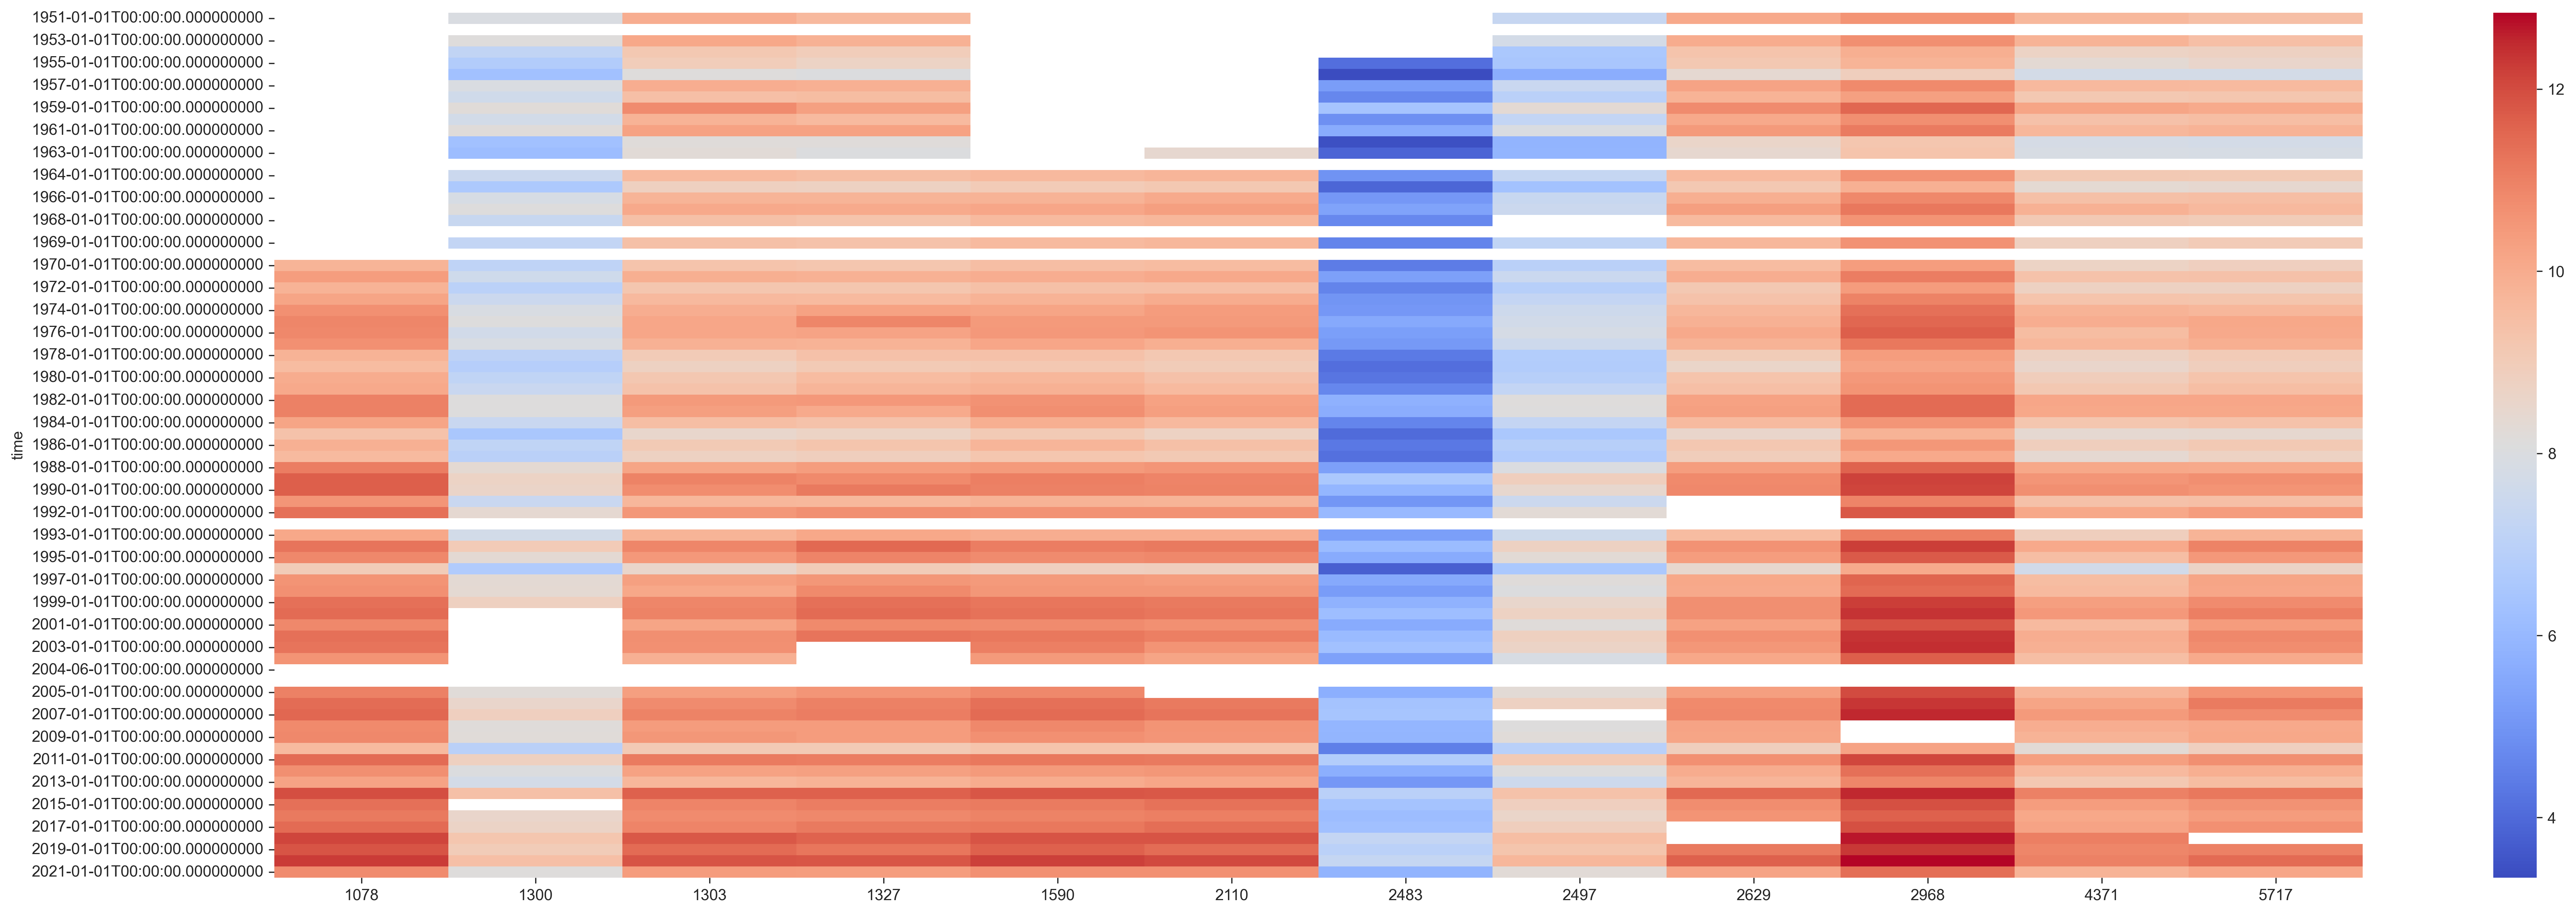

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plot
sns.set_style('ticks')
fig1, ax1 = plt.subplots(dpi = 300, figsize = (30,10))

sns.heatmap(df_T, cmap='coolwarm', annot=False, ax = ax1)
# _r reverses the normal order of the color map 'RdYlGn'

#sns.heatmap(df, cmap='coolwarm', annot=True, vmin = 8, vmax = 12, ax = ax)
#ax1.set_xticklabels(df_T.index.strftime('%Y'))
plt.show()
#fig1.savefig('NRW_Annual_Temp_Stripes_01.png')


# Reference temperature: Mean temperature between 1950 and 2022


In [37]:
idx = (df_T.index <= pd.Timestamp('2022')) & (df_T.index >= pd.Timestamp('1950'))

In [38]:
temp_mean = df_T.loc[idx].mean()
temp_mean

1078    10.765769
1300     7.833906
1303     9.997571
1327    10.075588
1590    10.398448
2110    10.308966
2483     5.330597
2497     7.739118
2629     9.940455
2968    11.161176
4371     9.516429
5717     9.758696
dtype: float64

In [39]:
df_temp_diff = df_T - temp_mean # broadcast operation
df_temp_diff.tail()

,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4371,5717
time,,,,,,,,,,,,
2017-01-01,0.664231,0.826094,0.922429,1.064412,0.781552,1.081034,0.929403,1.130882,NaN,0.758824,0.703571,0.901304
2018-01-01,1.354231,1.406094,1.792429,1.524412,1.461552,1.541034,1.929403,1.750882,NaN,1.508824,1.533571,NaN
2019-01-01,1.074231,1.176094,1.442429,1.164412,1.221552,1.111034,1.669403,1.530882,1.229545,1.138824,1.373571,1.231304
2020-01-01,1.484231,1.606094,1.842429,1.744412,1.781552,1.751034,1.949403,1.960882,1.689545,1.678824,1.483571,1.691304
2021-01-01,0.014231,0.306094,0.422429,0.294412,0.271552,0.351034,0.519403,0.520882,0.299545,0.208824,0.283571,0.391304


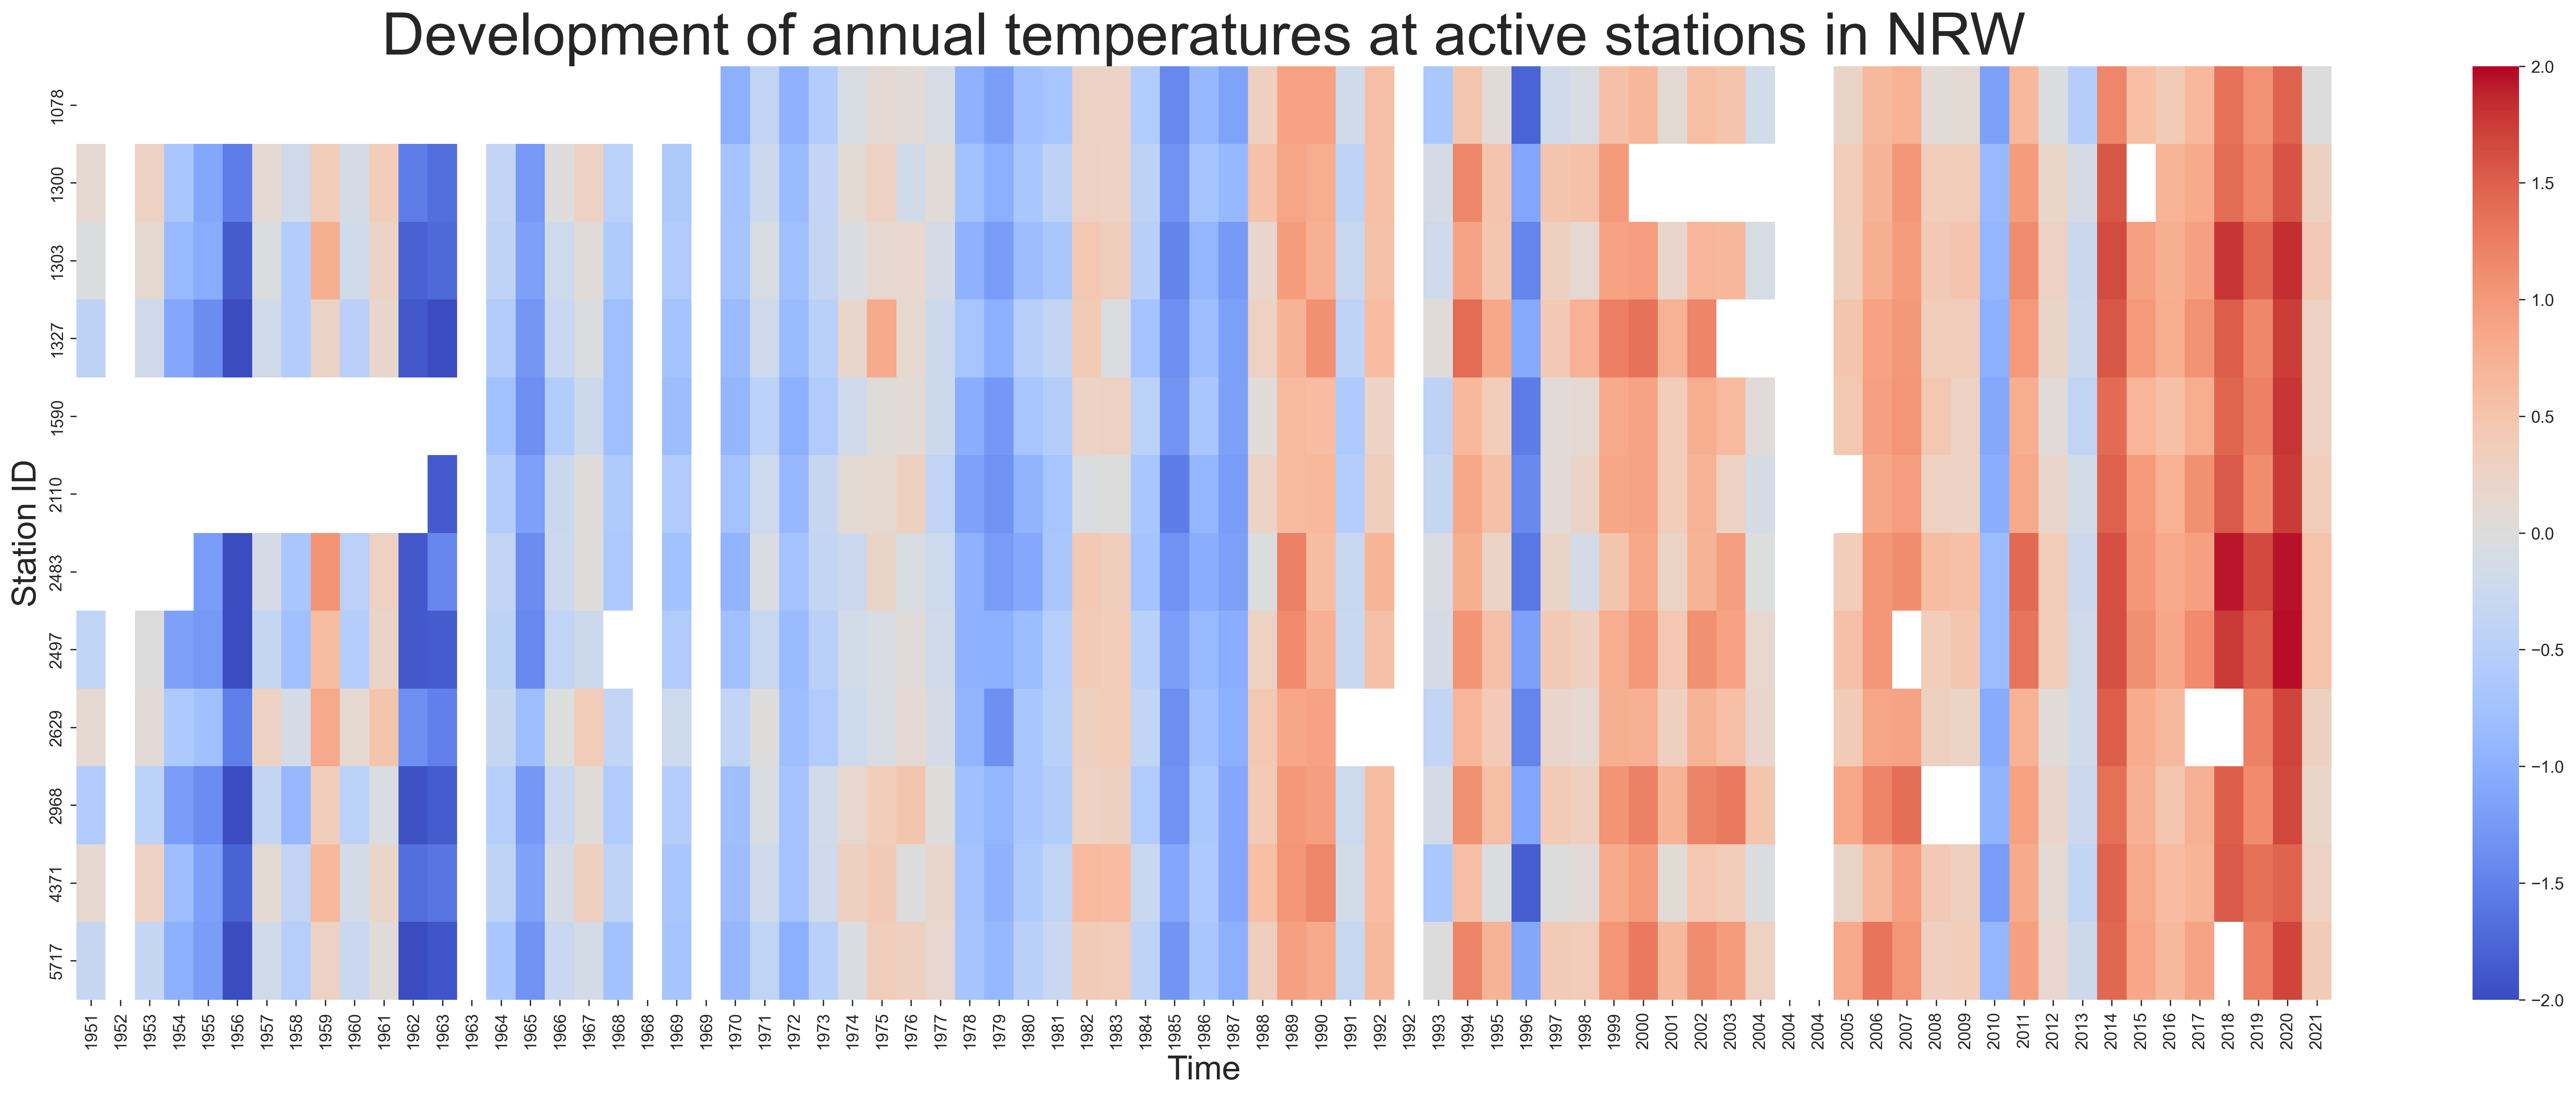

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plot
sns.set_style('ticks')
fig3, ax3 = plt.subplots(dpi = 300, figsize = (30,10))

sns.heatmap(df_temp_diff.T, cmap='coolwarm', annot=False, fmt = ".1f", vmin = -2, vmax = 2, ax = ax3)
ax3.set_xticklabels(df_T.index.strftime('%Y'))
ax3.set_ylabel("Station ID", fontsize = 20)
ax3.set_xlabel("Time", fontsize = 20)
ax3.set_title("Development of annual temperatures at active stations in NRW", fontsize = 35)

#fig3.savefig('example3.png')